In [1]:
import torch
leishu=4
device0 = torch.device('cuda:5' if torch.cuda.is_available() else "cpu")#训练集gpu
device1 = torch.device('cuda:5' if torch.cuda.is_available() else "cpu")#测试集gpu

In [2]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader,TensorDataset,Dataset
import numpy as np
import torch



In [3]:

def text2token(text,tokenizer,max_length=100):
    text2id = tokenizer(
        text, max_length=max_length, padding='max_length', truncation=True, return_tensors="pt"
    )
    input_ids=text2id["input_ids"].tolist()
    attention_mask=text2id["attention_mask"].tolist()
    return input_ids,attention_mask
def data2token(data_,tokenizer):
    text=[i for i in data_['title'].values]
    input_ids,attention_mask=text2token(text,tokenizer)
    data_['input_ids']=input_ids
    data_['attention_mask']=attention_mask
    return data_

class SentimentDataset(Dataset):
    def __init__(self,df):
        self.dataset = df
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        text = self.dataset.loc[idx, "title"]
        label = self.dataset.loc[idx, "label"]
        input_ids = self.dataset.loc[idx, "input_ids"]
        attention_mask = self.dataset.loc[idx, "attention_mask"]
        sample = {"text": text, "label": label,"input_ids":input_ids,"attention_mask":attention_mask}
        # print(sample)
        return sample
    


In [4]:
data_train=pd.read_csv("../data/train.csv",header=None)
data_val=pd.read_csv("../data/test.csv",header=None)

data_train.columns=['label','title','00']
data_val.columns=['label','title','00']
del data_train['00']
del data_val['00']

data_train_label=data_train['label'].tolist()
data_val_label=data_val['label'].tolist()

data_train_label=[i-1 for i in data_train_label]
data_val_label=[i-1 for i in data_val_label]

data_train['label']=data_train_label
data_val['label']=data_val_label


tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

data_train=data2token(data_train,tokenizer)
data_val=data2token(data_val,tokenizer)

#按batch_size分
batch_size=32
train_loader = DataLoader(
    SentimentDataset(data_train), 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0
)
test_loader = DataLoader(
    SentimentDataset(data_val), 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0
)

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch.nn.functional as F

class fn_cls(nn.Module):
    def __init__(self,device):
        super(fn_cls, self).__init__()
        self.model = AutoModel.from_pretrained("bert-base-uncased")
        self.model.resize_token_embeddings(len(tokenizer))##############
        self.model.to(device)
#         self.dropout = nn.Dropout(0.5)
        self.l1 = nn.Linear(768, leishu)

    def forward(self, x, attention_mask=None):
        outputs = self.model(x, attention_mask=attention_mask)
#         print(outputs[0])torch.Size([8, 100, 768])
#         print(outputs[1])torch.Size([8, 768])
#         print(outputs[0][:,0,:])torch.Size([8, 768])
        x = outputs[1]
#         x = self.dropout(x)
        x = self.l1(x)
        return x
softmax = nn.Softmax(dim=1)
criterion = nn.CrossEntropyLoss()#weight=weight

In [6]:
# 定义日志（data文件夹下，同级目录新建一个data文件夹）
import time
import datetime
import pytz
tz = pytz.timezone('Asia/Shanghai')
def write_log(w):
    file_name = '../data/' + datetime.date.today().strftime('%m%d') + "_{}.log".format("bert_base_loss")
    t0 = datetime.datetime.now(tz).strftime('%H:%M:%S')
    info = "{} : {}".format(t0, w)
    print(info)
    with open(file_name, 'a') as f:
        f.write(info + '\n')

In [7]:
from sklearn import metrics
import numpy as np
from tqdm import tqdm

def test(device_test):
    cls.to(device_test)
    cls.eval()

    epoch_loss=0
    total=0
    correct=0
    output_all=[]
    label_all=[]
    for batch_idx,batch in enumerate(test_loader):
        with torch.no_grad():
#             print(batch['label'])
            label=batch['label'].to(device_test)#batch size * 1
            label_all.append(label.view(-1,1))
            input_ids=torch.stack(batch['input_ids']).t().to(device_test)#batch size * 100
            attention_mask=torch.stack(batch['attention_mask']).t().to(device_test)#batch size * 100
            
            #计算输出
            output = cls(input_ids, attention_mask=attention_mask)#batch size * 1
            total+=len(output)
            
            #计算loss
            
#             print(output,label)
            loss = criterion(output, label)
            epoch_loss+=loss
            ave_loss=epoch_loss/total
            
            #四舍五入
            output=softmax(output)
            output=output.argmax(dim=1)
            output_all.append(output)
            
            #计算准确率
            add_correct=(output== label).sum().item()
            correct+=add_correct
            acc=correct/total
            
            if batch_idx%5==0:
                print('[{}/{} ({:.0f}%)]\t正确分类的样本数：{}，样本总数：{}，准确率：{}，ave_loss：{}'.format(
                    batch_idx, len(test_loader),100.*batch_idx/len(test_loader), 
                    correct, total,acc,
                    ave_loss
                    ),end= "\r")
            
            
            
    #结束：
    write_log('正确分类的样本数：{}，样本总数：{}，准确率：{}，ave_loss：{}'.format(
                    correct, total,acc,
                    ave_loss))
    
#     can't convert cuda:5 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
    output_all=torch.cat(output_all,0)
    label_all=torch.cat(label_all,0)
    
    output_all=np.array(output_all.cpu())
    label_all=np.array(label_all.cpu())
    acc_score=metrics.accuracy_score(label_all,output_all)
    write_log(metrics.classification_report(label_all,output_all))
    write_log("准确率:"+str(acc_score))
    
    return acc,epoch_loss.item()

# test(device1)

In [8]:
def badloss(correct_bi,output_sm):
#     print('badloss')
    loss=0
    for i in range(len(output_sm)):
#         print(correct_bi[i].item())
        if correct_bi[i].item() is False:
            loss=loss-torch.log(1-max(output_sm[i]))
#             print(0)
        else:
#             print(1)
            continue
#     print('bad_loss:',loss)
    return loss


def train_one_epoch(min_test_epoch_loss,device_train,epoch_num):
    write_log("______________________________________________")
    write_log("______________________________________________")
    write_log("_______________train epoch"+str(epoch_num)+" start_______________")
    write_log("______________________________________________")
    write_log("______________________________________________")
    cls.to(device_train)
    cls.train()
    loss_mode=0
    epoch_loss=0
    total=0
    correct=0
    batch_correct=0
    output_all=[]
    label_all=[]
    for batch_idx,batch in enumerate(train_loader):
        label=batch['label'].to(device_train)#batch size * 1
        label_all.append(label.view(-1,1))
        input_ids=torch.stack(batch['input_ids']).t().to(device_train)#batch size * 100
        attention_mask=torch.stack(batch['attention_mask']).t().to(device_train)#batch size * 100

        #计算输出
        output = cls(input_ids, attention_mask=attention_mask)#batch size * 1
        output_sm=softmax(output)
        
        with torch.no_grad():
            output_end=output_sm.argmax(dim=1)
            correct_bi= output_end == label
#             print(correct_bi)
            add_correct=(correct_bi).sum().item()
            batch_correct=add_correct/len(output)
#             print(batch_correct)
        
        #计算loss
        loss_c = criterion(output, label)
        if batch_correct<0.9:
            loss = loss_c
        else:
            loss_mode+=1
            loss = loss_c + badloss(correct_bi,output_sm)/10
#         print('loss:',loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        with torch.no_grad():
            #四舍五入
            output_all.append(output_end)
            
            #epoch_loss
            total+=len(output)
            epoch_loss += loss_c
            ave_loss=epoch_loss/total
            
            #计算准确率
            correct+=add_correct
            acc=correct/total
            
            if batch_idx%5==0:
                print('[{}/{} ({:.0f}%)]\t正确分类的样本数：{}，样本总数：{}，准确率：{}，ave_loss：{}, mode: {}____'.format(
                    batch_idx, len(train_loader),100.*batch_idx/len(train_loader),
                    correct, total, acc,
                    ave_loss, loss_mode
                    ),end= "\r")
                loss_mode=0
            
            
            
    #结束：
    
#     can't convert cuda:5 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
    with torch.no_grad():
        output_all=torch.cat(output_all,0)
        label_all=torch.cat(label_all,0)

        output_all=np.array(output_all.cpu())
        label_all=np.array(label_all.cpu())
        acc_score=metrics.accuracy_score(label_all,output_all)
        
#     print(metrics.classification_report(label_all,output_all))
    write_log('__________________train end__________________')
    write_log('正确分类的样本数：{}，样本总数：{}，准确率：{}，ave_loss：{}'.format(
                    correct, total,acc,
                    ave_loss))
    
    write_log("准确率:"+str(acc_score))
    
    write_log('__________________test start__________________')
    test_acc,test_epoch_loss=test(device1)
    if min_test_epoch_loss>test_epoch_loss:
        min_test_epoch_loss=test_epoch_loss
        write_log("store model")
        end = time.time()
        torch.save(cls,"../data/bert_loss/cls_loss_"+str(epoch_num)+"_"+str(round(test_acc,5))+'_'+str(round(test_epoch_loss,5))+'_'+str(end)+".model")
    
    write_log('train_acc:'+str(acc)+'  train_epoch_loss:'+str(epoch_loss.item())+'  test_acc:'+str(test_acc)+'  test_epoch_loss:'+str(test_epoch_loss))
    write_log('__________________test end__________________')
    
    train_acc_l.append(acc)
    train_epoch_loss_l.append(epoch_loss.item())
    test_acc_l.append(test_acc)
    test_epoch_loss_l.append(test_epoch_loss)
    write_log("______________________________________________")
    write_log("______________________________________________")
    write_log("_______________train epoch "+str(epoch_num)+" end_______________")
    write_log("______________________________________________")
    write_log("______________________________________________")
    return min_test_epoch_loss
    

    
def train(epoch_num):
    min_test_epoch_loss=999999
    for i in range(epoch_num):
        write_log("Current lr : {}".format(optimizer.state_dict()['param_groups'][0]['lr']))
        min_test_epoch_loss=train_one_epoch(min_test_epoch_loss,device0,i)
        scheduler.step()

    
# train_one_epoch(device0,0)
# train()

In [9]:
cls = fn_cls(device0)
# cls=torch.load("../data/cls_0.86353_183.34991_1642153938.7560434.model",map_location=device0)
from torch import optim
optimizer = optim.Adam(cls.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
# test(device1)
train_acc_l=[]
train_epoch_loss_l=[]
test_acc_l=[]
test_epoch_loss_l=[]
train(10)

00:15:01 : ______________________________________________
00:15:01 : ______________________________________________
00:15:01 : _______________train epoch0 start_______________
00:15:01 : ______________________________________________
00:15:01 : ______________________________________________
00:28:16 : __________________train end__________________5918980245595，ave_loss：0.012833165936172009, mode: 3____
00:28:16 : 正确分类的样本数：103148，样本总数：120000，准确率：0.8595666666666667，ave_loss：0.012832747772336006
00:28:16 : 准确率:0.8595666666666667
00:28:16 : __________________test start__________________
00:28:32 : 正确分类的样本数：6754，样本总数：7600，准确率：0.8886842105263157，ave_loss：0.01029693428426981578175
00:28:32 :               precision    recall  f1-score   support

           0       0.93      0.87      0.90      1900
           1       0.90      0.97      0.93      1900
           2       0.84      0.86      0.85      1900
           3       0.88      0.86      0.87      1900

    accuracy                       

KeyboardInterrupt: 

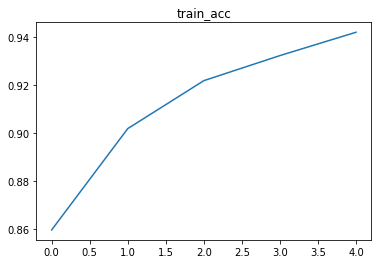

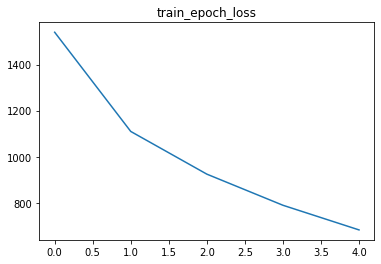

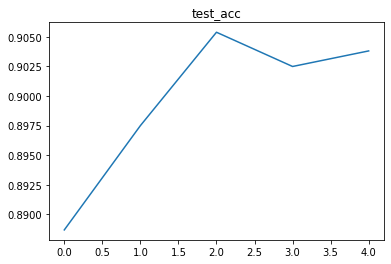

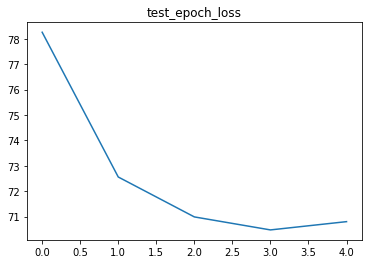

In [10]:
import matplotlib.pyplot as plt
def _plt():
    plt.plot([i for i in range(len(train_acc_l))], train_acc_l)
    plt.title('train_acc')
    plt.show()
    plt.plot([i for i in range(len(train_epoch_loss_l))], train_epoch_loss_l)
    plt.title('train_epoch_loss')
    plt.show()
    plt.plot([i for i in range(len(test_acc_l))], test_acc_l)
    plt.title('test_acc')
    plt.show()
    plt.plot([i for i in range(len(test_epoch_loss_l))], test_epoch_loss_l)
    plt.title('test_epoch_loss')
    plt.show()
_plt()